In [139]:
import importlib
import time
import os
import neat
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.cm as cm

from IPython.display import Video
from IPython.display import Image

import eval_env
from bcolors import bcolors as bcolors

import ca_environment as caenv
import ca_agent as caag

import neat_stuff.visualize as visualize

import graphics as gfx


In [146]:
importlib.reload(caag)
importlib.reload(visualize)
importlib.reload(caenv)
importlib.reload(eval_env)
importlib.reload(gfx)


<module 'graphics' from '/Users/aidanbarbieux/CSC/580-CSC/WIDDAK/nca/graphics.py'>

## Example code for running the slime mold

CAAgent ID: Lame Agent
	KERNEL: von_n
	AGENT_TYPE: slime mold
CAAgent ID: Random Agent
	KERNEL: von_n
	AGENT_TYPE: slime mold


2022-11-19 08:34:59.904598: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


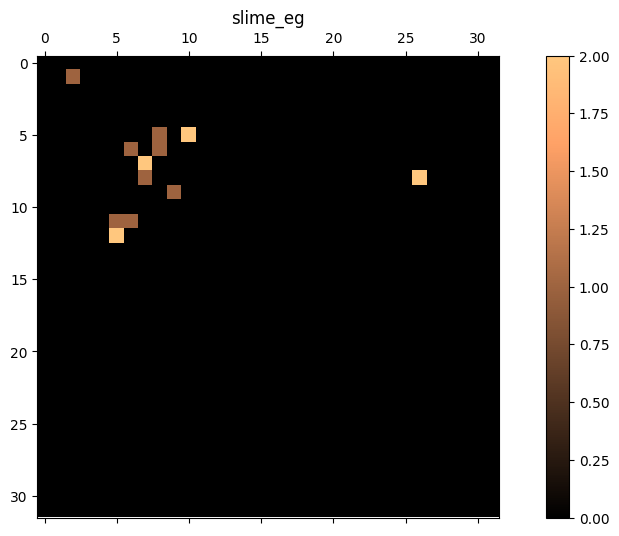

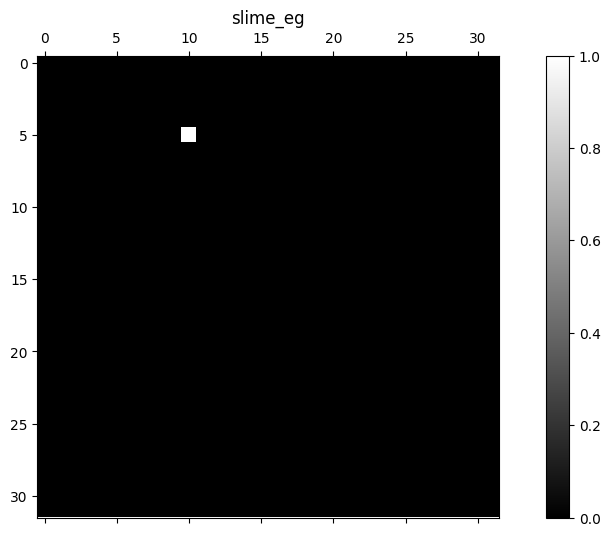

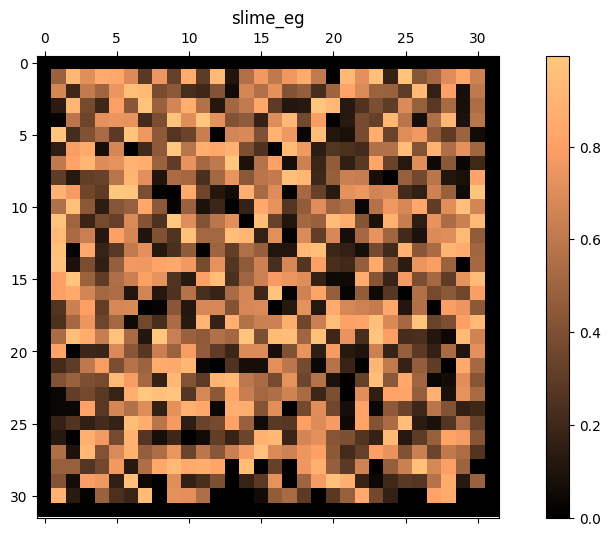

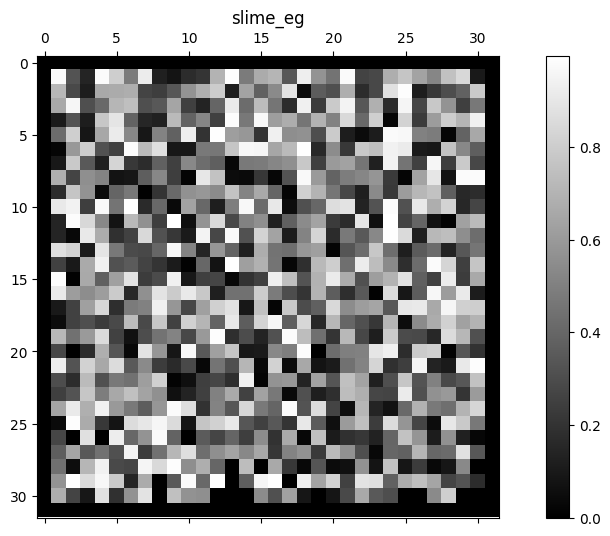

In [15]:
env = caenv.CAEnvironment("slime_eg")
env.gen_padded_food()
env.innoculate()
env.display()

ag = caag.CAAgent("Lame Agent")
def lame_rules(chunk, env):
    return [1] * env.n_channels

ag.set_rule_func(lame_rules)

rag = caag.CAAgent("Random Agent")
def rand_rules(chunk, env):
    return np.random.random(env.n_channels)
rag.set_rule_func(rand_rules)
print(ag.display())
print(rag.display())


env.start_new_video(channels=(env.food_i, env.life_i), cmaps = (cm.copper,cm.gray))
for _ in range(30):
    # ag.apply_to_env(env, log=True, vid_speed=3)
    rag.apply_to_env(env, log=True, vid_speed=5)
env.display()
Video(env.save_video())

## Load in test environments

In [87]:
import numpy as np
import scipy.signal as signal
import scipy.sparse as sparse
from tqdm import tqdm

importlib.reload(eval_env)
t_folders = [((6,32,32), "32x32/"), ((6,256,256), "256x256/")]
tenvs = eval_env.load_tests(*t_folders[0])

food_map = 3
life_map = 1

tenv = caenv.CAEnvironment(id = tenvs[str(food_map)][str(life_map)].id)
chs = np.copy(tenvs[str(food_map)][str(life_map)].channels)
tenv.update_shape(chs.shape)
tenv.channels = chs
grid = tenv.channels[tenv.hidden_i]
mask = tenv.channels[tenv.life_i]
food = tenv.channels[tenv.food_i]

grid += food
tenv.start_new_video(channels=[tenv.hidden_i], cmaps = [cm.hot])

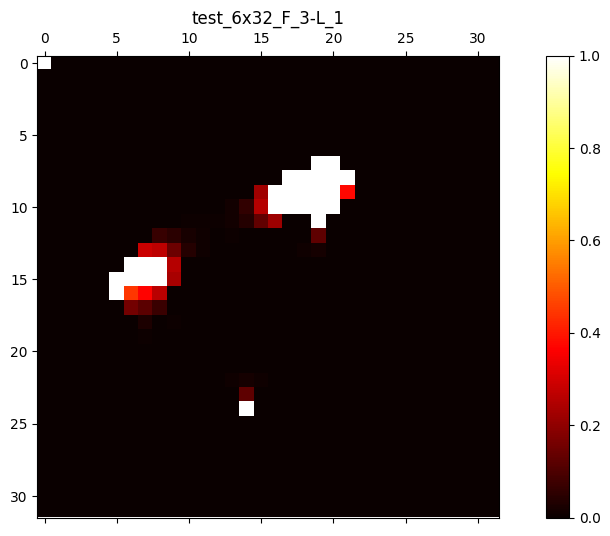

In [88]:
def diffuse_grid_conv(env, vid=True, food_rate=1, n=50, decay=0.25, kernel=np.array([[0.25,0.5,0.25],[0.5,0,0.5],[0.25,0.5,0.25]])):
    grid = env.channels[env.hidden_i]
    mask = env.channels[env.life_i]
    food = env.channels[env.food_i]
    for _ in tqdm(range(n), leave=False):
        grid = signal.convolve2d(grid, kernel, mode='same', boundary='wrap')
        grid = grid * mask * decay
        grid = np.clip(grid+food*food_rate, 0, 1)
        if vid:
            env.channels[env.hidden_i] = grid
            env.channels[env.hidden_i][0,0] = 1
            env.add_state_to_video()
    if not vid:
        env.channels[env.hidden_i] = grid

diffuse_grid_conv(tenv)
tenv.display(channels=[tenv.hidden_i], cmaps = [cm.hot])

In [265]:
def diffuse_grid(env, log=True, vid_name="./diffusion.mp4", food_rate=0.25, n=50, decay=0.11):
    grid = env.channels[env.hidden_i]
    mask = env.channels[env.life_i]
    food = env.channels[env.food_i]
    if log:
        vid = gfx.VideoWriter(vid_name, fps=10)
    for _ in tqdm(range(n), leave=False):
        # Sets top left cell to 1 to reference the color map
        grid[0,0] = 11
        if log:
            vid.add_concat_grids([tenv.channels[tenv.life_i],grid], cols=2, cmaps=[cm.hot, cm.hot])

        grid[1:,:] += grid[:-1,:]
        grid[:-1,:] += grid[1:,:] 
        grid[:,1:] += grid[:,:-1]
        grid[:,:-1] += grid[:,1:]
        grid = grid * mask * decay
        grid = np.clip(grid+food*food_rate, 0, 10)
        # If cell is on a road, 10% of the time remove all food
        # grid = np.where(np.logical_and(mask, np.random.random(grid.shape) < 0.3), 0, grid) 
    vid.close()           



# Innoculate roads with food
tenv.channels[tenv.hidden_i] += tenv.channels[tenv.food_i]
# Fills all roads with 5 food
tenv.channels[tenv.hidden_i] = tenv.channels[tenv.life_i] * 3

tenv.channels[tenv.hidden_i] = diffuse_grid(tenv, food_rate=0.15, n=130, decay=0.11)


In [45]:
def run_diffuse_tests(env,
                        ns=[50,100],
                        decays = [0.15, 0.2, 0.25, 0.33, 0.35],
                        food_rates = [0.00000001, 0.00001, 0.001, 0.1, 0.25, 0.5],
                        ):

    tenv = caenv.CAEnvironment(id = env.id)
    chs = np.copy(env.channels)
    tenv.update_shape(chs.shape)
    with tqdm(total=sum(ns)*len(food_rates)*len(decays)) as pbar:
        for n in ns:
            for decay in decays:
                for food_rate in food_rates:
                    pbar.set_description(f"n={n}, decay={decay}, food_rate={food_rate}")
                    tenv.channels = np.copy(chs)
                    tenv.start_new_video(channels=[tenv.hidden_i], cmaps = [cm.hot])
                    diffuse_grid(tenv, food_rate=food_rate, n=n, decay=decay)
                    tenv.save_video(fname = f"./diffusion_tests/decay_{decay}/food_rate_{food_rate}_{tenv.id}_{n}_iters.mp4")
                    pbar.update(n)

run_diffuse_tests(tenv)

n=100, decay=0.35, food_rate=0.5: 100%|██████████| 4500/4500 [00:41<00:00, 108.94it/s]  


100%|██████████| 10/10 [00:03<00:00,  3.32it/s]


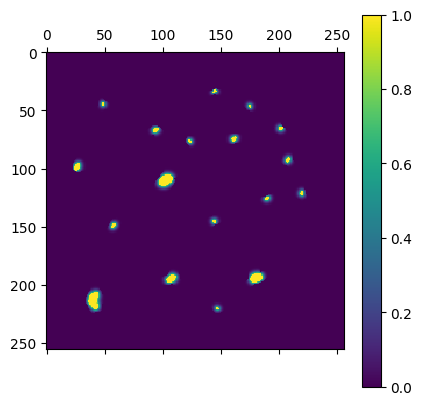

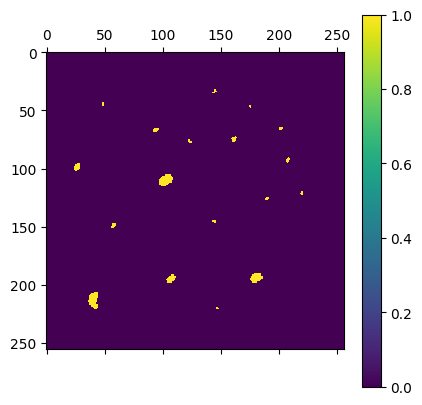

  4%|▎         | 1/27 [00:03<01:29,  3.46s/it]

Saving Video with n=10, food_rate=0.5, decay=0.5


100%|██████████| 10/10 [00:03<00:00,  3.22it/s]


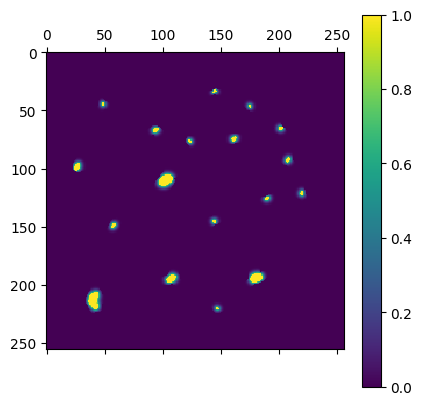

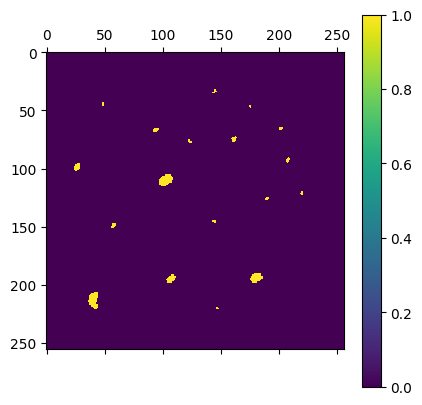

  7%|▋         | 2/27 [00:07<01:27,  3.51s/it]

Saving Video with n=10, food_rate=0.5, decay=0.75


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


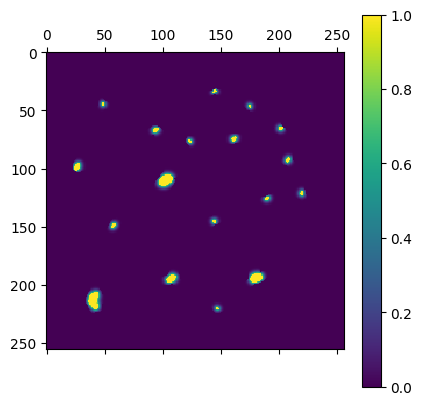

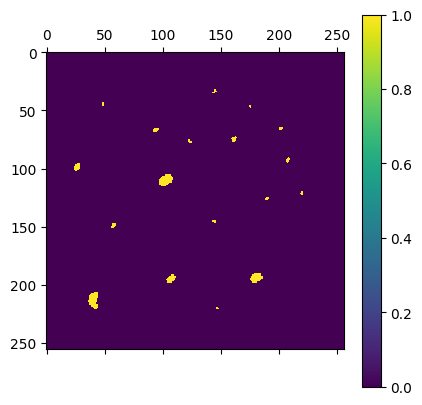

 11%|█         | 3/27 [00:10<01:27,  3.65s/it]

Saving Video with n=10, food_rate=0.5, decay=1


100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


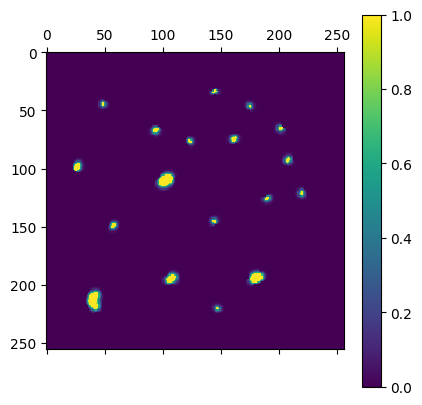

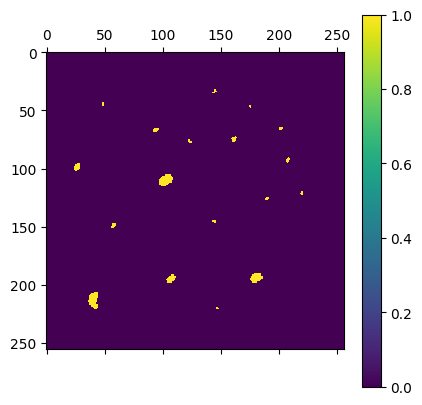

 15%|█▍        | 4/27 [00:14<01:22,  3.61s/it]

Saving Video with n=10, food_rate=1, decay=0.5


100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


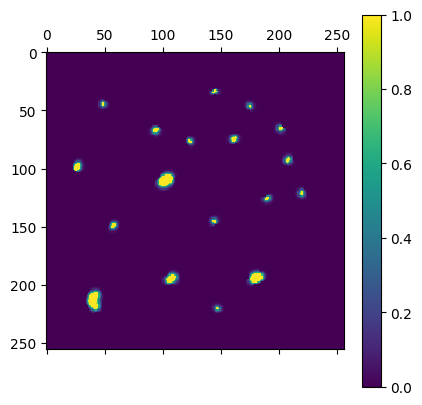

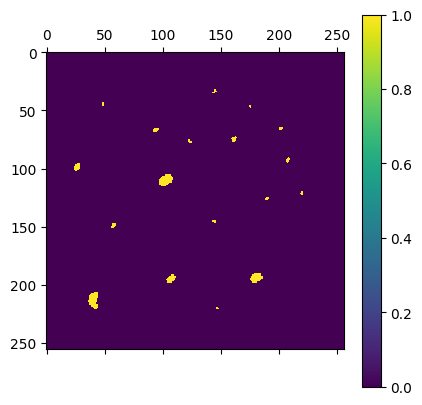

 19%|█▊        | 5/27 [00:18<01:22,  3.73s/it]

Saving Video with n=10, food_rate=1, decay=0.75


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


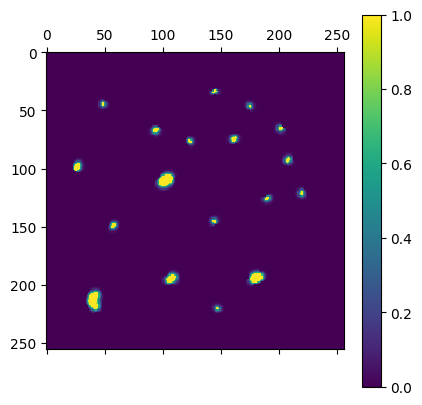

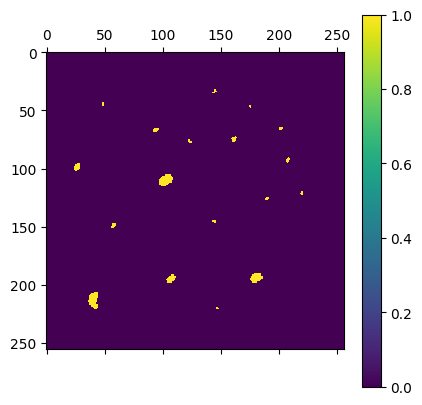

 22%|██▏       | 6/27 [00:22<01:19,  3.76s/it]

Saving Video with n=10, food_rate=1, decay=1


 22%|██▏       | 6/27 [00:24<01:27,  4.15s/it]


KeyboardInterrupt: 

In [167]:
run_diffuse_tests(tenv)

Running Diffusion on env 3 1


100%|██████████| 10/10 [00:02<00:00,  4.84it/s]


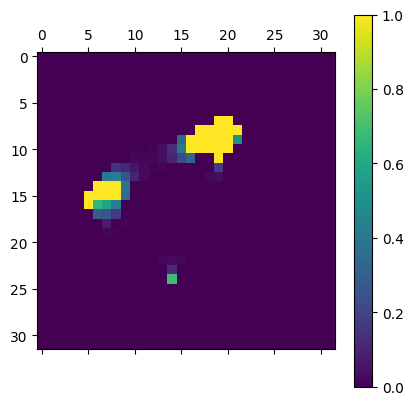

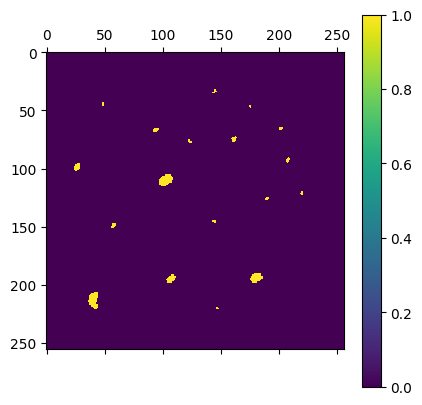

  4%|▎         | 1/27 [00:02<01:05,  2.52s/it]

Saving Video with n=10, food_rate=0.5, decay=0.5


100%|██████████| 10/10 [00:02<00:00,  4.85it/s]


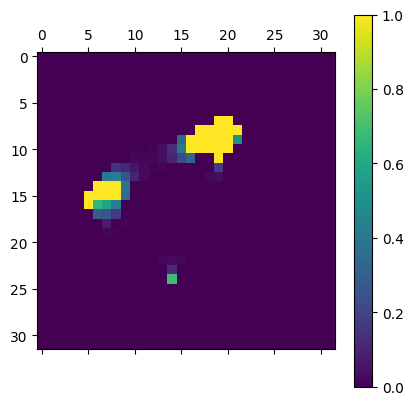

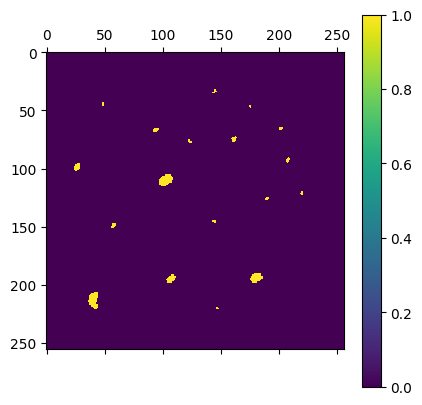

  7%|▋         | 2/27 [00:04<01:02,  2.49s/it]

Saving Video with n=10, food_rate=0.5, decay=0.75


100%|██████████| 10/10 [00:02<00:00,  4.64it/s]


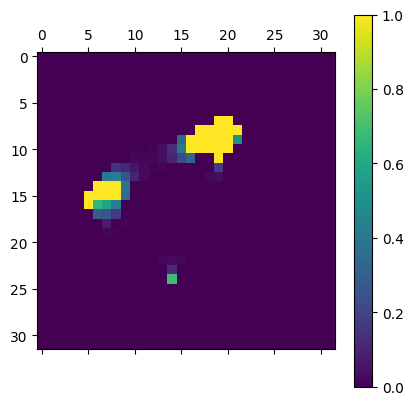

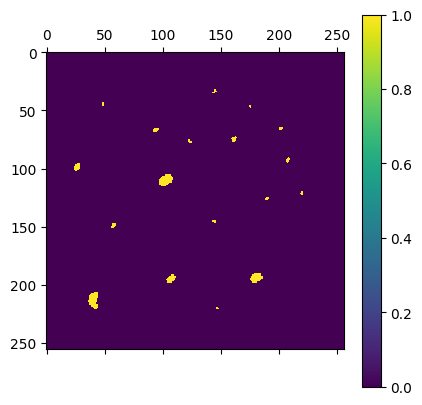

 11%|█         | 3/27 [00:07<01:00,  2.53s/it]

Saving Video with n=10, food_rate=0.5, decay=1


100%|██████████| 10/10 [00:02<00:00,  4.48it/s]


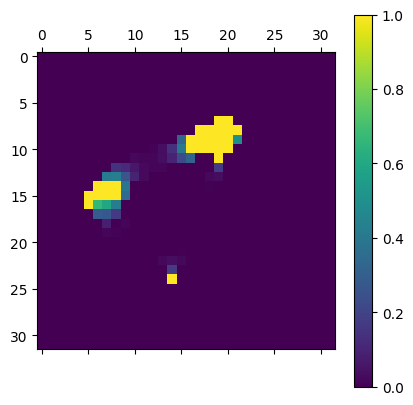

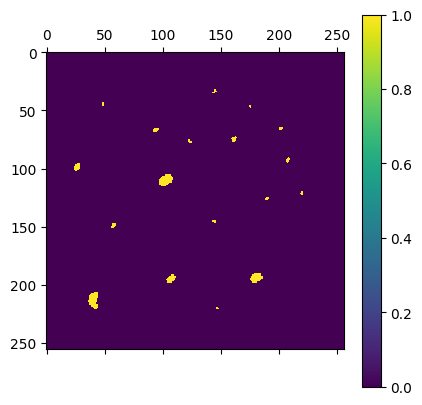

 15%|█▍        | 4/27 [00:10<01:04,  2.80s/it]

Saving Video with n=10, food_rate=1, decay=0.5


100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


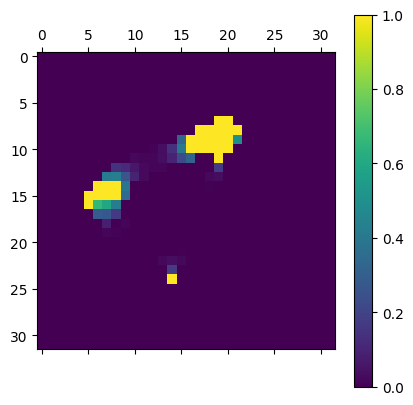

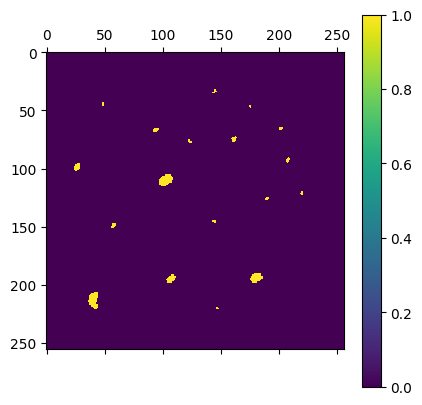

 19%|█▊        | 5/27 [00:13<01:01,  2.80s/it]

Saving Video with n=10, food_rate=1, decay=0.75


100%|██████████| 10/10 [00:02<00:00,  4.12it/s]


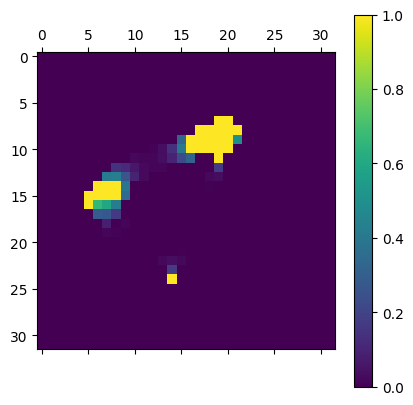

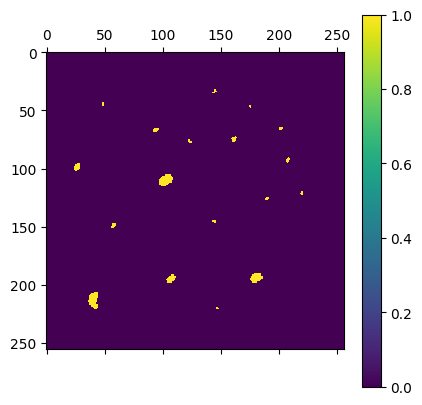

 22%|██▏       | 6/27 [00:16<00:59,  2.82s/it]

Saving Video with n=10, food_rate=1, decay=1


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


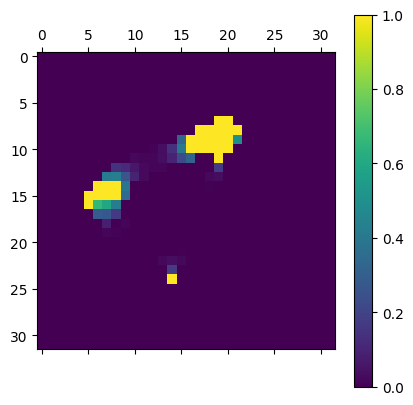

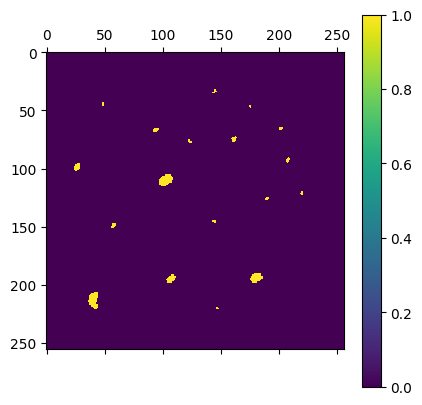

 26%|██▌       | 7/27 [00:19<00:57,  2.85s/it]

Saving Video with n=10, food_rate=2, decay=0.5


100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


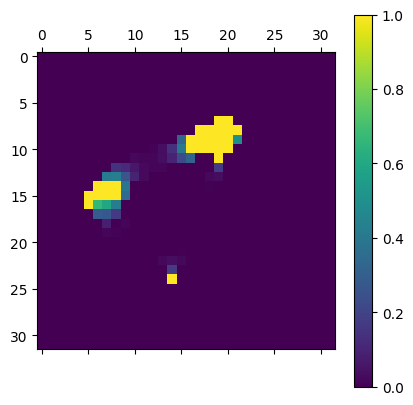

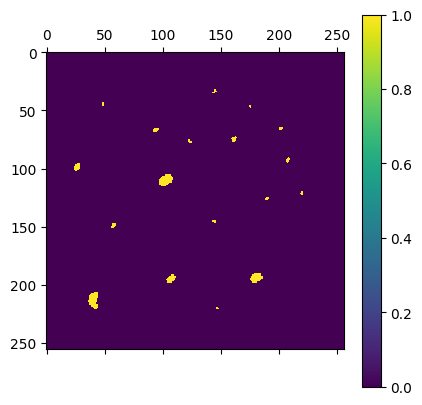

 30%|██▉       | 8/27 [00:22<00:55,  2.92s/it]

Saving Video with n=10, food_rate=2, decay=0.75


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


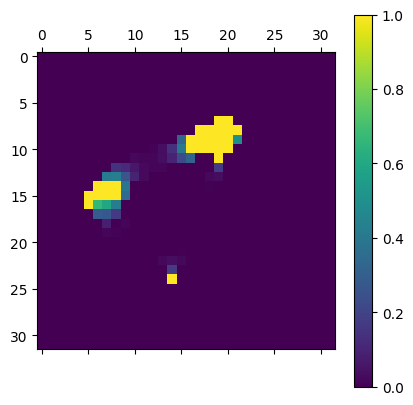

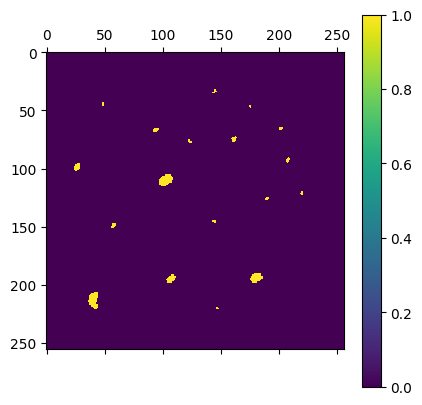

 33%|███▎      | 9/27 [00:25<00:53,  2.99s/it]

Saving Video with n=10, food_rate=2, decay=1


 33%|███▎      | 9/27 [00:33<01:06,  3.69s/it]


KeyboardInterrupt: 

In [166]:
'''
    Runs diffuse tests for each environment in the test environment dictionary
'''
small_envs = eval_env.load_tests(*t_folders[0])
large_envs = eval_env.load_tests(*t_folders[1])
def run_diffuse_tests_all(envs, ns=[10,50,100], food_rates = [0.5, 1, 2], decays = [0.5, 0.75, 1]):
    for fkey in envs.keys():
        for ekey in envs[fkey].keys():
            print(f"Running Diffusion on env {fkey} {ekey}")
            run_diffuse_tests(envs[fkey][ekey], ns=ns, food_rates=food_rates, decays=decays)

run_diffuse_tests_all(small_envs)
run_diffuse_tests_all(large_envs)

# Playground for testing functions

In [260]:
def diffuse_grid(env, log=True, food_rate=1, n=50, decay=0.25):
    grid = env.channels[env.hidden_i]
    mask = env.channels[env.life_i]
    food = env.channels[env.food_i]
    if log:
        vid = gfx.VideoWriter("./diffusion.mp4", fps=10)
    for _ in tqdm(range(n), leave=False):
        # Sets top left cell to 1 to reference the color map
        grid[0,0] = 11
        if log:
            vid.add_concat_grids([tenv.channels[tenv.life_i],grid], cols=2, cmaps=[cm.hot, cm.hot])

        grid[1:,:] += grid[:-1,:] #* mask[1:, :] 
        grid[:-1,:] += grid[1:,:] #* mask[:-1, :]
        grid[:,1:] += grid[:,:-1] #* mask[:,1:] * decay
        grid[:,:-1] += grid[:,1:] #* mask[:,:-1] * decay
        grid = grid * mask * decay
        grid = np.clip(grid+food*food_rate, 0, 10)
        # If cell is on a road, 10% of the time remove all food
        # grid = np.where(np.logical_and(mask, np.random.random(grid.shape) < 0.3), 0, grid) 
    vid.close()           



# Innoculate roads with food
tenv.channels[tenv.hidden_i] += tenv.channels[tenv.food_i]
# Fills all roads with 5 food
tenv.channels[tenv.hidden_i] = tenv.channels[tenv.life_i] * 3

tenv.channels[tenv.hidden_i] = diffuse_grid(tenv, food_rate=0.15, n=130, decay=0.11)
